# Progetto di statistica

## Carico tutto ciò che c'è da caricare.

Librerie e dati

In [1]:
import pandas as pd
import scipy

from pygam import LogisticGAM, s, te
from pygam import LinearGAM, s, f, te

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier

import os
import sys

# Define the current working directory
cwd = os.getcwd()

# load the data
data = pd.read_csv(cwd + '/health_data.csv')
data

,Unnamed: 0,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,0.0,18393.0,1,168.0,62.0,110.0,80.0,0,0,0,0,1,0
1,1,1.0,20228.0,0,156.0,85.0,140.0,90.0,2,0,0,0,1,1
2,2,2.0,18857.0,0,165.0,64.0,130.0,70.0,2,0,0,0,0,1
3,3,3.0,17623.0,1,169.0,82.0,150.0,100.0,0,0,0,0,1,1
4,4,4.0,17474.0,0,156.0,56.0,100.0,60.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,69995,99993.0,19240.0,1,168.0,76.0,120.0,80.0,0,0,1,0,1,0
69996,69996,99995.0,22601.0,0,158.0,126.0,140.0,90.0,1,1,0,0,1,1
69997,69997,99996.0,19066.0,1,183.0,105.0,180.0,90.0,2,0,0,1,0,1
69998,69998,99998.0,22431.0,0,163.0,72.0,135.0,80.0,0,1,0,0,0,1


## Prime operazioni di pulizia

Trasforma categoriche in `str`, butta via `NaN` (spoiler: non ce ne sono), butta via le colonne inutili, converti l'età in anni, elimina i valori assurdi, aggiungi la colonna del `BMI` just in case, sposta la colonna `cardio` in fondo.

In [2]:
# Create a working copy to avoid modifying the original data
df = data.copy()

# Define th list of categoriacl variables
categorical = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']

# Convert inf to NaN, although according to the data description there are no Infs
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove NaNs, although according to the data description there are no NaNs
df.dropna(inplace=True)

# Drop the id column and -1
df.drop(['id', 'Unnamed: 0'], axis=1, inplace=True)

# Convert age in days
df['age'] = df['age']/365.25

# Filter for impossible values for height, weight, ap_hi, ap_lo
df = df[(df['height'] > 130) & (df['height'] < 220)]
df = df[(df['weight'] > 30) & (df['weight'] < 200)]
df = df[(df['ap_hi'] > 60) & (df['ap_hi'] < 240)]
df = df[(df['ap_lo'] > 40) & (df['ap_lo'] < 200)]
df = df[df['age'] <100]

# Add a new column for the BMI
df['BMI'] = df['weight'] / (df['height'] / 100) ** 2

# Filter for reasonable values for BMI
df = df[(df['BMI'] > 6) & (df['BMI'] < 70)]

# Convert all categorical variables to strings,
# this will be undone at a later stage (remember to do it before the model)
df[categorical] = df[categorical].astype(str)

# Reset index for... resons?
df.reset_index(drop=True, inplace=True)

# Put the cardio column at the end
df = df[[c for c in df if c not in ['cardio']] + ['cardio']]

# Here's the resulting df
df


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,BMI,cardio
0,50.357290,1,168.0,62.0,110.0,80.0,0,0,0,0,1,21.967120,0
1,55.381246,0,156.0,85.0,140.0,90.0,2,0,0,0,1,34.927679,1
2,51.627652,0,165.0,64.0,130.0,70.0,2,0,0,0,0,23.507805,1
3,48.249144,1,169.0,82.0,150.0,100.0,0,0,0,0,1,28.710479,1
4,47.841205,0,156.0,56.0,100.0,60.0,0,0,0,0,0,23.011177,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68636,52.676249,1,168.0,76.0,120.0,80.0,0,0,1,0,1,26.927438,0
68637,61.878166,0,158.0,126.0,140.0,90.0,1,1,0,0,1,50.472681,1
68638,52.199863,1,183.0,105.0,180.0,90.0,2,0,0,1,0,31.353579,1
68639,61.412731,0,163.0,72.0,135.0,80.0,0,1,0,0,0,27.099251,1


## Rapida analisi del dataset

Proprietà del datset

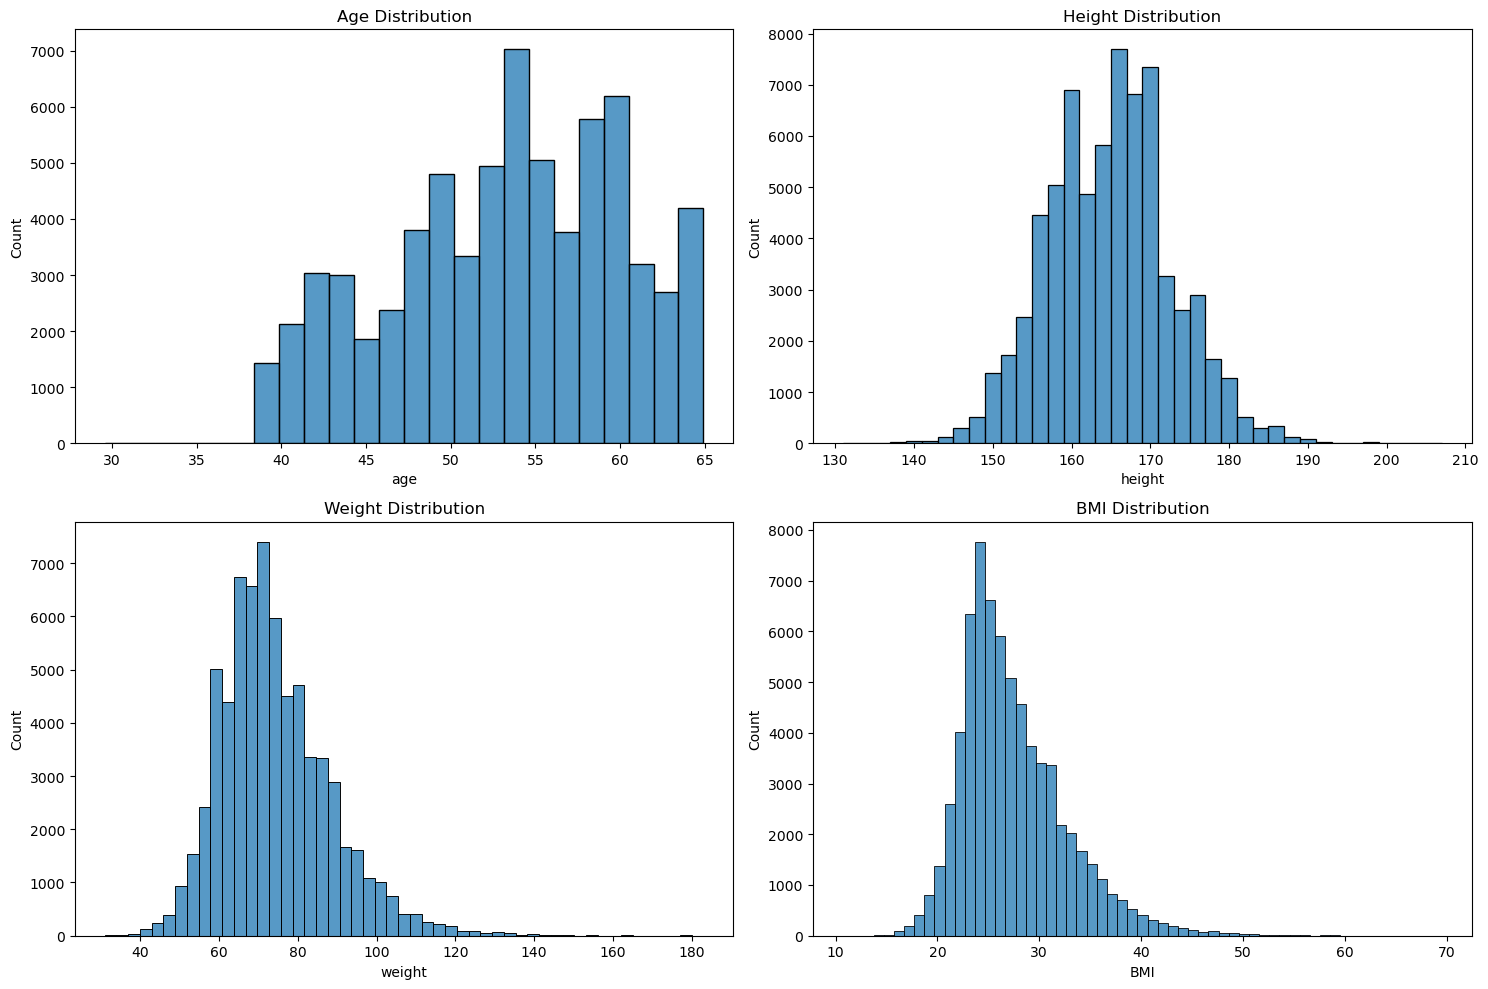

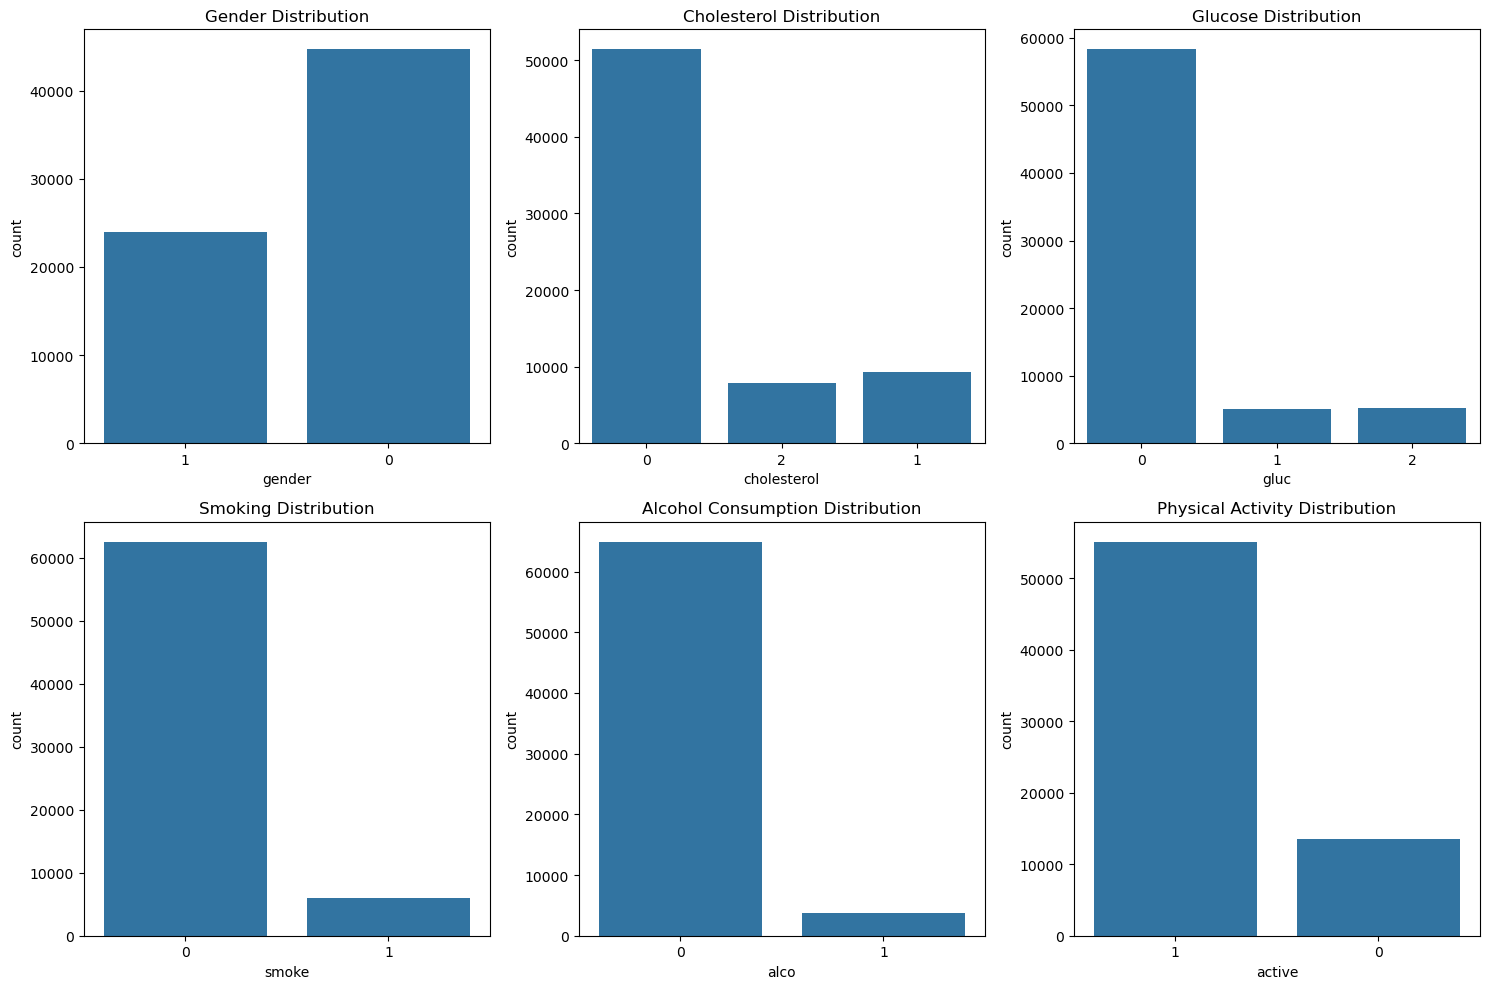

In [3]:
# Create a copy of the cleaned dataset to use for EDA
df_eda = df.copy()

#########################
## Numerical Variables ##
#########################

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(df_eda, x='age', binwidth=1.5, ax=ax[0, 0])
ax[0, 0].set_title('Age Distribution')
sns.histplot(df_eda, x='height', binwidth=2, ax=ax[0, 1])
ax[0, 1].set_title('Height Distribution')
sns.histplot(df_eda, x='weight', binwidth=3, ax=ax[1, 0])
ax[1, 0].set_title('Weight Distribution')
sns.histplot(df_eda, x='BMI', binwidth=1, ax=ax[1, 1])
ax[1, 1].set_title('BMI Distribution')
plt.tight_layout()
plt.show()

###########################
## Categorical Variables ##
###########################

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
sns.countplot(x='gender', data=df_eda,ax=ax[0, 0])
ax[0, 0].set_title('Gender Distribution')
sns.countplot(x='cholesterol', data=df_eda, ax=ax[0, 1])
ax[0, 1].set_title('Cholesterol Distribution')
sns.countplot(x='gluc', data=df_eda, ax=ax[0, 2])
ax[0, 2].set_title('Glucose Distribution')
sns.countplot(x='smoke', data=df_eda, ax=ax[1, 0])
ax[1, 0].set_title('Smoking Distribution')
sns.countplot(x='alco', data=df_eda, ax=ax[1, 1])
ax[1, 1].set_title('Alcohol Consumption Distribution')
sns.countplot(x='active', data=df_eda, ax=ax[1, 2])
ax[1, 2].set_title('Physical Activity Distribution')
plt.tight_layout()
plt.show()



## EDA

Explore data relationships

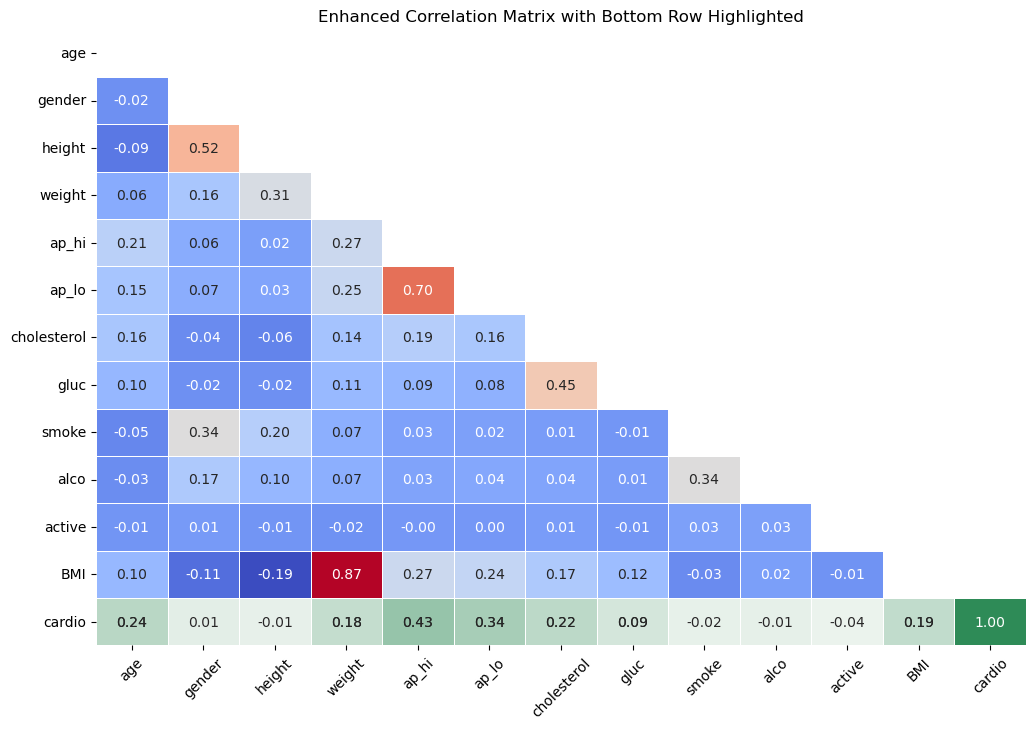

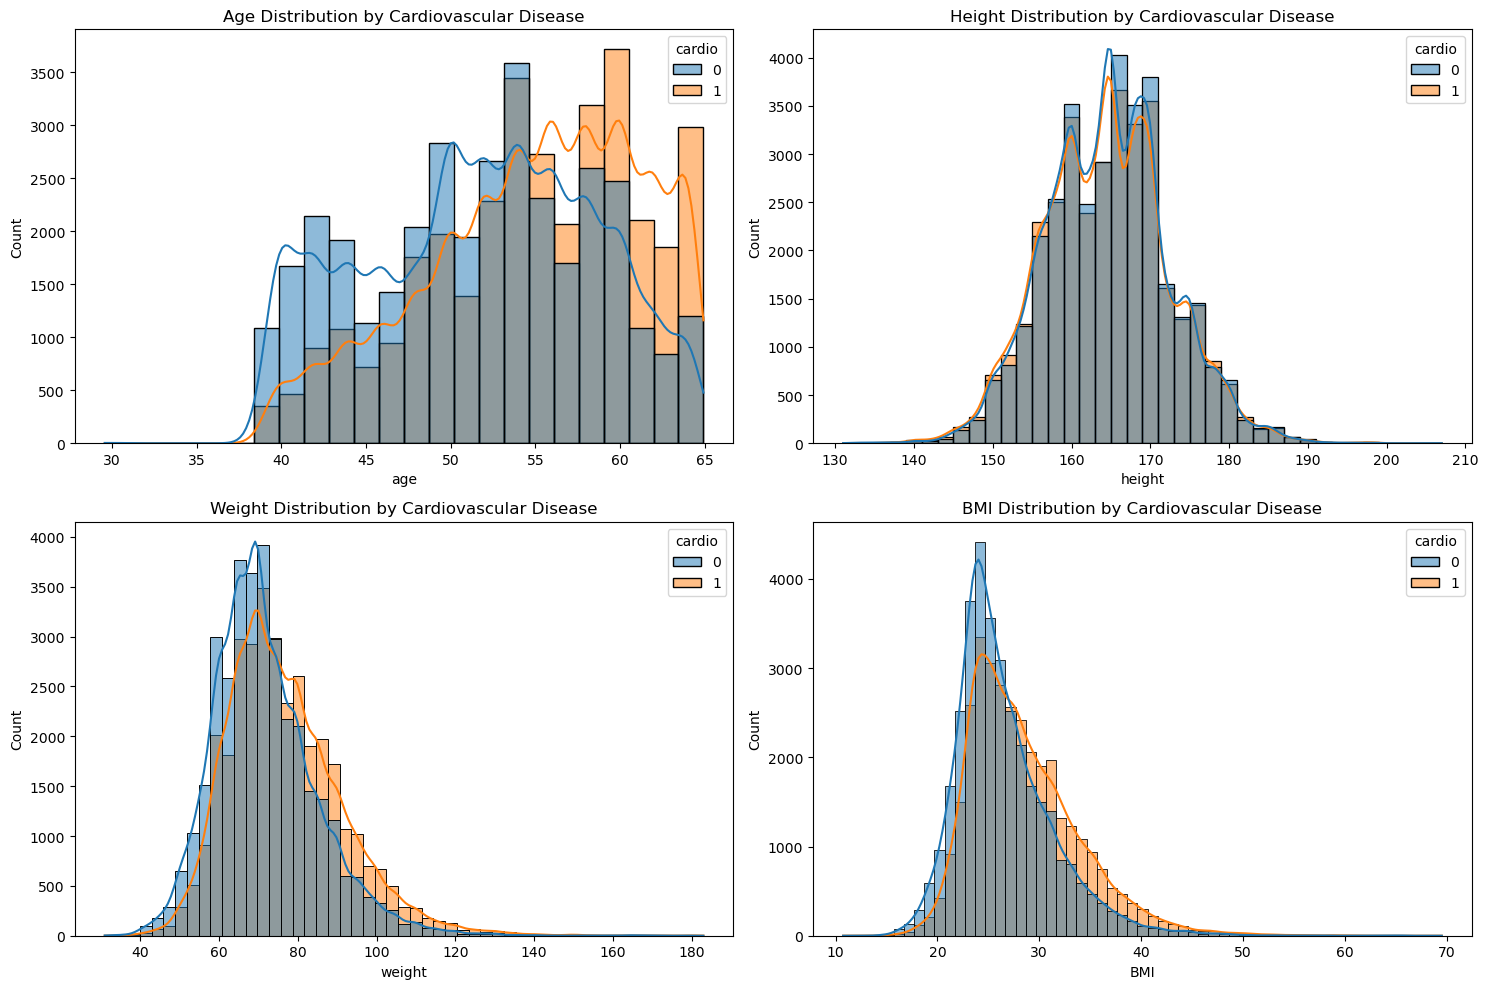

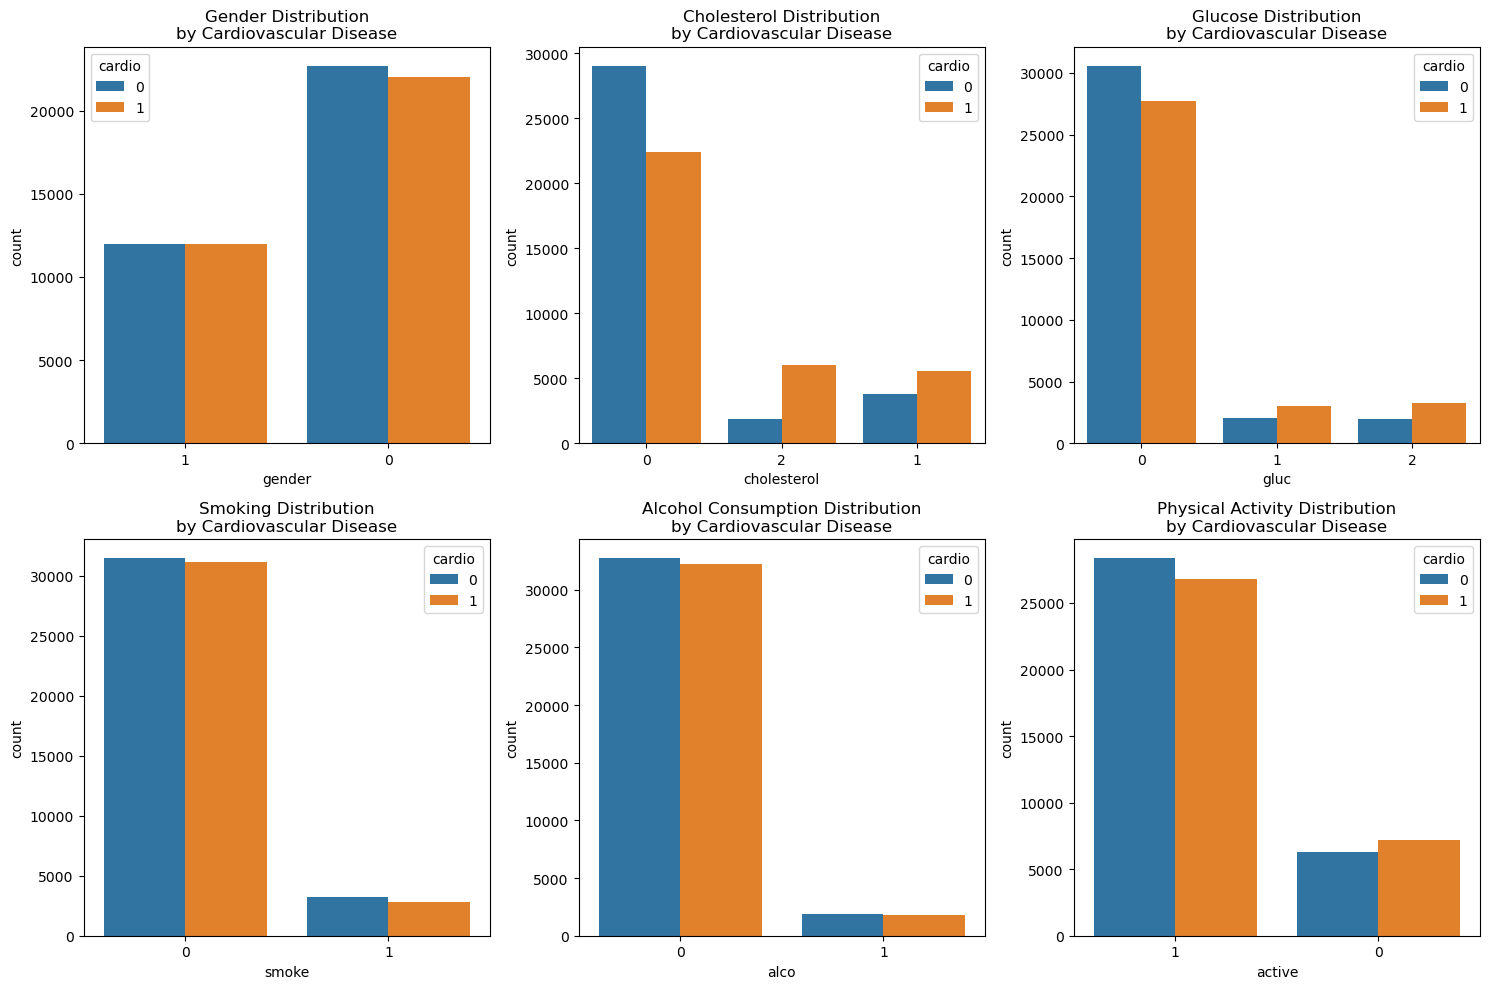

In [4]:
# Create a copy of the cleaned dataset to use for EDA
df_eda = df.copy()

####################################################
## CORRELATION MATRIX WITH HIGHLIGHTED BOTTOM ROW ##
####################################################

plt.figure(figsize=(12, 8))
# Creating a mask for the upper triangle
mask_upper = np.triu(np.ones_like(df.corr(), dtype=bool))
# Creating a mask for all but the bottom row (for highlighting)
mask_not_bottom = np.ones_like(df.corr(), dtype=bool)
mask_not_bottom[-1, :] = False  # Unmask the bottom row
# Plot the main heatmap with the upper triangle masked
sns.heatmap(df.corr(), annot=True, mask=mask_upper, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=False)
# Overlay with the bottom row highlighted
# Adjust 'highlight_cmap' to change the highlight color
highlight_cmap = sns.light_palette("seagreen", as_cmap=True)
sns.heatmap(df.corr(), annot=True, mask=mask_not_bottom, cmap=highlight_cmap, fmt=".2f", linewidths=.5, cbar=False)
plt.xticks(rotation=45)
plt.title('Enhanced Correlation Matrix with Bottom Row Highlighted')
plt.show()

#######################################################
## DISTRIBUTION OF DATA ACCORDING TO TARGET VARIABLE ##
#######################################################

## Numerical ##

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(df_eda, x='age', hue='cardio', kde=True, binwidth=1.5, ax=ax[0, 0])
ax[0, 0].set_title('Age Distribution by Cardiovascular Disease')
sns.histplot(df_eda, x='height', hue='cardio', kde=True, binwidth=2, ax=ax[0, 1])
ax[0, 1].set_title('Height Distribution by Cardiovascular Disease')
sns.histplot(df_eda, x='weight', hue='cardio', kde=True, binwidth=3, ax=ax[1, 0])
ax[1, 0].set_title('Weight Distribution by Cardiovascular Disease')
sns.histplot(df_eda, x='BMI', hue='cardio', kde=True, binwidth=1, ax=ax[1, 1])
ax[1, 1].set_title('BMI Distribution by Cardiovascular Disease')
plt.tight_layout()
plt.show()

## Categorical ##

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
sns.countplot(x='gender', hue='cardio', data=df_eda,ax=ax[0, 0])
ax[0, 0].set_title('Gender Distribution\nby Cardiovascular Disease')
sns.countplot(x='cholesterol', hue='cardio', data=df_eda, ax=ax[0, 1])
ax[0, 1].set_title('Cholesterol Distribution\nby Cardiovascular Disease')
sns.countplot(x='gluc', hue='cardio', data=df_eda, ax=ax[0, 2])
ax[0, 2].set_title('Glucose Distribution\nby Cardiovascular Disease')
sns.countplot(x='smoke', hue='cardio', data=df_eda, ax=ax[1, 0])
ax[1, 0].set_title('Smoking Distribution\nby Cardiovascular Disease')
sns.countplot(x='alco', hue='cardio', data=df_eda, ax=ax[1, 1])
ax[1, 1].set_title('Alcohol Consumption Distribution\nby Cardiovascular Disease')
sns.countplot(x='active', hue='cardio', data=df_eda, ax=ax[1, 2])
ax[1, 2].set_title('Physical Activity Distribution\nby Cardiovascular Disease')
plt.tight_layout()
plt.show()



Possiamo buttare `gluc, alco, height, ap_lo` perché sono piuttosto correlate con altre variabili, mentre l'altezza ha la stessa distribuzione in cardio e non cardio.

## LOGISTIC REGRESSION CON IL LINEAR MODEL

Logistic regression, con full model, null model, senza le variabili di cui sopra, togliendo le variabili con P Value alto. Quello dopo sarà con le cose bilanciate.

In [5]:
# Create a copy of the cleaned dataset to use for logistic regression
df_regression = df.copy()

# Convert all categorical variables to integers
df_regression[categorical] = df_regression[categorical].astype(int)

################
## FULL MODEL ##
################

# Create a copy for the full model
df_full = df_regression.copy()

# Create a dummied version
df_full = pd.get_dummies(df_full, drop_first=True)

# For logistic regression, statsmodels requires us to add a constant to our model
df_full['intercept'] = 1.0

# Fit the logistic regression model
full_model = sm.Logit(df_full['cardio'], df_full.drop(columns=['cardio'])).fit()

# Display the model's summary
print(full_model.summary())

################
## NULL MODEL ##
################

# Fit the null model
null_model = sm.Logit(df_full['cardio'], df_full['intercept']).fit()
print(null_model.summary())

##################
## NESTED MODEL ##
##################

# Create a copy for the nested model
nested_model = df_regression.copy()

# Drop the unwanted columns, except age
nested_model.drop(columns = ['gluc', 'alco', 'height', 'ap_lo'], inplace=True)

# Create a dummied version
nested_model = pd.get_dummies(nested_model, drop_first=True)

# For logistic regression, statsmodels requires us to add a constant to our model
nested_model['intercept'] = 1.0

# Fit the logistic regression model
nested_model = sm.Logit(nested_model['cardio'], nested_model.drop(columns=['cardio'])).fit()

# Display the model's summary
print(nested_model.summary())

#################################
## NESTED MODEL WITHOUT GENDER ##
#################################

# Create a copy for the nested model without gender

nested_model_no_gender = df_regression.copy()

# Drop the unwanted columns
nested_model_no_gender.drop(columns = ['gluc', 'alco', 'height', 'ap_lo', 'gender'], inplace=True)

# Create a dummied version
nested_model_no_gender = pd.get_dummies(nested_model_no_gender, drop_first=True)

# For logistic regression, statsmodels requires us to add a constant to our model
nested_model_no_gender['intercept'] = 1.0

# Fit the logistic regression model
nested_model_no_gender = sm.Logit(nested_model_no_gender['cardio'], nested_model_no_gender.drop(columns=['cardio'])).fit()

# Display the model's summary
print(nested_model_no_gender.summary())

##############################
## ALTERNATIVE NESTED MODEL ##
##############################

# Create a copy for the alternative nested model
nested_model_alt = df_regression.copy()

# Drop the unwanted columns
nested_model_alt.drop(columns = ['gender', 'height', 'BMI'], inplace=True)

# Create a dummied version
nested_model_alt = pd.get_dummies(nested_model_alt, drop_first=True)

# For logistic regression, statsmodels requires us to add a constant to our model
nested_model_alt['intercept'] = 1.0

# Fit the logistic regression model
nested_model_alt = sm.Logit(nested_model_alt['cardio'], nested_model_alt.drop(columns=['cardio'])).fit()

# Display the model's summary
print(nested_model_alt.summary())

########################
## COMPARE THE MODELS ##
########################

# Create a function to perform the likelihood ratio test
def likelihood_ratio_test(full_model, nested_model):
    LR_statistic = -2*(nested_model.llf - full_model.llf)
    df = len(full_model.params) - len(nested_model.params)
    p_val = scipy.stats.chi2.sf(LR_statistic, df)
    return LR_statistic, p_val

# Perform the likelihood ratio test
print("FULL MODEL VS NULL MODEL")
LR_statistic, p_val = likelihood_ratio_test(full_model, null_model)
print('Likelihood Ratio statistic: ', LR_statistic)
print('p-value: ', p_val)

print("NESTED MODEL VS FULL MODEL")
LR_statistic, p_val = likelihood_ratio_test(full_model, nested_model)
print('Likelihood Ratio statistic: ', LR_statistic)
print('p-value: ', p_val)

print("NESTED MODEL WITHOUT GENDER VS NESTED MODEL")
LR_statistic, p_val = likelihood_ratio_test(nested_model, nested_model_no_gender)
print('Likelihood Ratio statistic: ', LR_statistic)
print('p-value: ', p_val)

print("ALTERNATIVE NESTED MODEL VS NESTED MODEL")
LR_statistic, p_val = likelihood_ratio_test(nested_model_alt, nested_model)
print('Likelihood Ratio statistic: ', LR_statistic)
print('p-value: ', p_val)

Optimization terminated successfully.
         Current function value: 0.560952
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 cardio   No. Observations:                68641
Model:                          Logit   Df Residuals:                    68628
Method:                           MLE   Df Model:                           12
Date:                Sat, 24 Feb 2024   Pseudo R-squ.:                  0.1907
Time:                        16:31:46   Log-Likelihood:                -38504.
converged:                       True   LL-Null:                       -47575.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
age             0.0516      0.001     38.033      0.000       0.049       0.054
gender         -0.0149    

In [6]:
# Create a copy of the cleaned dataset to use for logistic regression with balanced data
df_regression_balanced = df.copy()

# Convert all categorical variables to integers
df_regression_balanced[categorical] = df_regression_balanced[categorical].astype(int)

# Drop the "bad columns" ['gluc', 'alco', 'height', 'ap_lo', 'gender']
df_regression_balanced.drop(columns = ['gluc', 'alco', 'height', 'ap_lo', 'gender'], inplace=True)

# Find the number of samples in each class and for each categorical variable
print(df_regression_balanced['cardio'].value_counts())
print(df_regression_balanced['cholesterol'].value_counts())
print(df_regression_balanced['smoke'].value_counts())
print(df_regression_balanced['active'].value_counts())

# The above code returns the following:
# cardio
# 0    34673
# 1    33968
# Name: count, dtype: int64
# cholesterol
# 0    51469
# 1     9297
# 2     7875
# Name: count, dtype: int64
# smoke
# 0    62598
# 1     6043
# Name: count, dtype: int64
# active
# 1    55150
# 0    13491
# Name: count, dtype: int64

#Actually, the classes are balanced, so we don't need to do anything

cardio
0    34673
1    33968
Name: count, dtype: int64
cholesterol
0    51469
1     9297
2     7875
Name: count, dtype: int64
smoke
0    62598
1     6043
Name: count, dtype: int64
active
1    55150
0    13491
Name: count, dtype: int64


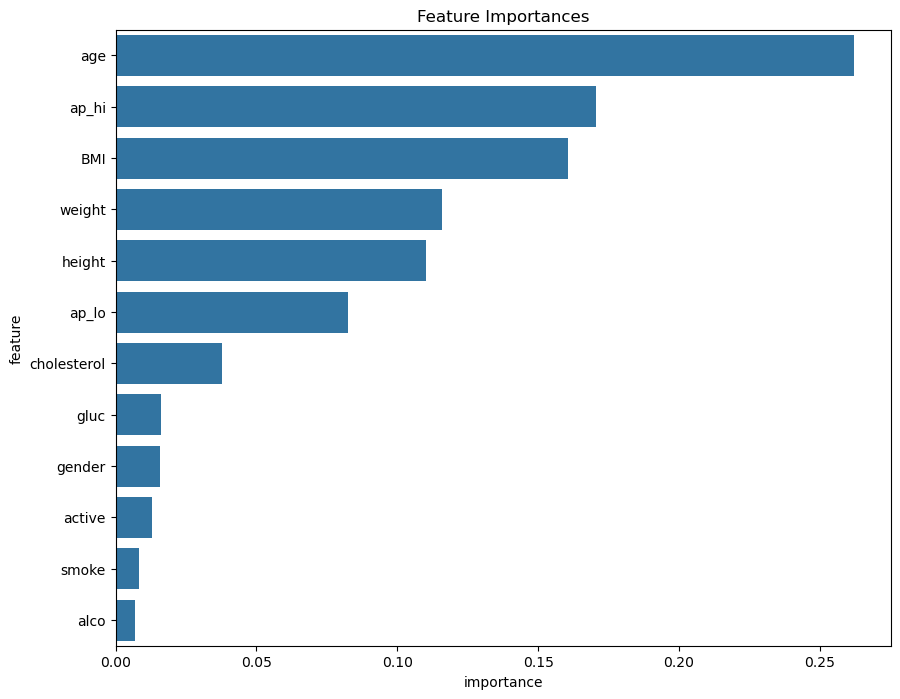

In [7]:
############################################
## FEATURE IMPORTANCE USING RANDOM FOREST ##
############################################

# Create a copy of the cleaned dataset to use for feature importance
df_feature_importance = df.copy()

# Divide the data into features and target
X = df_feature_importance.drop(columns=['cardio']).copy()
y = df_feature_importance['cardio'].copy()

# Create a random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
rf.fit(X_train, y_train)

# Get the feature importances
feature_importances = rf.feature_importances_

# Create a dataframe with the feature importances
feature_importances_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importances})

# Sort the dataframe by feature importance
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importances_df, x='importance', y='feature')
plt.title('Feature Importances')
plt.show()

/home/alberto/miniconda3/envs/Stats/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 500}
Accuracy: 0.7332653507174594
Precision: 0.7660604038044385
Recall: 0.6701211501970515
F1 Score: 0.7148863282466521


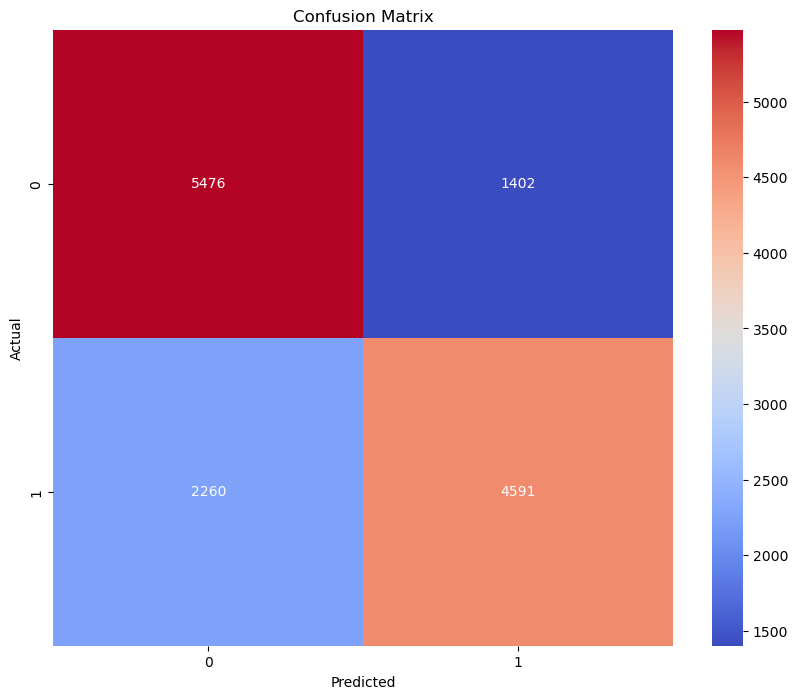

In [10]:
##############################
## RANDOM FOREST CLASSIFIER ##
##############################

# Create a copy of the cleaned dataset to use for the random forest classifier
df_rf = df.copy()

# Initialize the random forest classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# Split the data into features and target
X = df_rf.drop(columns=['cardio']).copy()
y = df_rf['cardio'].copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a GridSearchCV object
param_grid = {'n_estimators': [100, 500], 'max_depth': [10, 20, 30], 'max_features': [None, 'sqrt', 'log2']}

# Perform the grid search, saving the best hyperparameters and model
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_

# Print the best hyperparameters
print(best_params)

# Use the best estimator for predictions
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

# Assuming your y_test and y_pred are string type labels
precision = precision_score(y_test, y_pred, pos_label='1')
recall = recall_score(y_test, y_pred, pos_label='1')
f1 = f1_score(y_test, y_pred, pos_label='1')

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
